In [ ]:
!pip install pyspark
!pip install python-dotenv

In [ ]:
!pip install pyspark
!wget https://repo1.maven.org/maven2/net/snowflake/spark-snowflake_2.12/2.9.1-spark_3.1/spark-snowflake_2.12-2.9.1-spark_3.1.jar
!wget https://repo1.maven.org/maven2/net/snowflake/snowflake-jdbc/3.13.3/snowflake-jdbc-3.13.3.jar


--2025-05-09 21:19:34--  https://repo1.maven.org/maven2/net/snowflake/spark-snowflake_2.12/2.9.1-spark_3.1/spark-snowflake_2.12-2.9.1-spark_3.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 713233 (697K) [application/java-archive]
Saving to: ‘spark-snowflake_2.12-2.9.1-spark_3.1.jar’

spark-snowflake_2.1 100%[===================>] 696.52K  --.-KB/s    in 0.05s   

2025-05-09 21:19:34 (14.8 MB/s) - ‘spark-snowflake_2.12-2.9.1-spark_3.1.jar’ saved [713233/713233]

--2025-05-09 21:19:34--  https://repo1.maven.org/maven2/net/snowflake/snowflake-jdbc/3.13.3/snowflake-jdbc-3.13.3.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting 

In [ ]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os
from pyspark.sql.functions import explode, col, to_timestamp, substring
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, ArrayType

In [ ]:
from google.colab import userdata


storage_account_name = userdata.get("AZURE_ACCOUNT_NAME")
storage_account_key = userdata.get("AZURE_STORAGE_KEY")

storage_container_name = "kaggle-datasets"
parquet_blob_name = "github-dataset-full.parquet"

In [ ]:
# Creating Spark session
spark = SparkSession.builder \
    .appName("Read Parquet from Azure Blob Storage") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.2,com.microsoft.azure:azure-storage:8.6.6") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Remove garbage error texts
spark.sparkContext.setLogLevel("ERROR")

 Analytics Steps

 1.Load Parquet Files

In [ ]:
#Read the data from main file
users_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/non_list_data"
)

In [ ]:
#Read the data from main file
commits_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/commit_list_data"
)

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, coalesce, lit

2.Aggregate Developer Activity per User

In [ ]:
from pyspark.sql.functions import year, count

filtered_df = commits_df.filter(
    (year(commits_df.generate_at) >= 2008) &
    (year(commits_df.generate_at) <= 2018)
)

In [ ]:
commit_counts = filtered_df.groupBy("committer_id").agg(count("*").alias("commit_count"))

The above code groups all commits by user (committer_id) and counts how many commits each user made. The result is a table with each user's ID and their total number of commits.

In [ ]:
users_with_commits = users_df.join(
    commit_counts,
    users_df.id == commit_counts.committer_id,
    how="left"
)

This left joins the users_df with commit_counts, matching id from users with committer_id from commits, and keeps all users even those with no commits.

In [ ]:
users_with_commits = users_with_commits.withColumn(
    "commit_count",
    coalesce("commit_count", lit(0))
)

Some users did not have any commits, so NaN appears. We replace it with 0.

3. Compute Developer Activity Score

In [ ]:
users_with_score = users_with_commits.withColumn(
    "activity_score",
    3 * col("commit_count") +
    2 * col("public_repos") +
    1 * col("followers") +
    0.5 * col("public_gists")
)

This creates a new column called activity_score by:

Giving more importance to commits (×3)

Adding weight to public repos (×2), followers (×1), and gists (×0.5)

It uses col("...") to reference columns in PySpark.

Fix: Normalize Company Names

In [ ]:
from pyspark.sql.functions import lower, trim, regexp_replace

# Clean company names: lowercase, remove '@', strip spaces
users_normalized = users_with_score.withColumn(
    "company_cleaned",
    trim(lower(regexp_replace(col("company"), "@", "")))
).withColumn(
    "location",
    trim(lower(col("location")))
)

This will convert:

"@Microsoft " → "microsoft"

" Microsoft" → "microsoft"

"MICROSOFT" → "microsoft"

In [ ]:
users_filtered = users_normalized.filter(
    col("company_cleaned").isNotNull() &
    (col("company_cleaned") != "") &
    (col("company_cleaned") != "none") &
    col("location").isNotNull() &
    (col("location") != "") &
    (col("location") != "none")
)

Filter the Null company values

5.Aggregate by Company

In [ ]:
company_scores = users_filtered.groupBy("company_cleaned").sum("activity_score") \
    .withColumnRenamed("sum(activity_score)", "activity_score")


 This groups all users by company and sums their activity scores.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count, row_number

location_counts = users_filtered.groupBy("company_cleaned", "location").agg(count("*").alias("count"))

# Rank locations per company
windowSpec = Window.partitionBy("company_cleaned").orderBy(col("count").desc())

top_locations = location_counts.withColumn("rank", row_number().over(windowSpec)) \
    .filter(col("rank") == 1) \
    .drop("count", "rank")


This just renames the column to keep it clean.

In [ ]:
top_20 = company_scores.orderBy(col("activity_score").desc()).limit(20)

In [ ]:
top_20_with_location = top_20.join(top_locations, on="company_cleaned", how="left")

This sorts companies by total activity and takes the top 200.

In [ ]:
top_20_final = top_20_with_location \
    .withColumnRenamed("company_cleaned", "company") \
    .orderBy(col("activity_score").desc())

In [ ]:
print(top_20_final.columns)

['company', 'activity_score', 'location']


In [ ]:
top_20_final.show(truncate=False)

+--------------------------+--------------+-----------------+
|company                   |activity_score|location         |
+--------------------------+--------------+-----------------+
|microsoft                 |581301.5      |redmond, wa      |
|cocoapods                 |508770.0      |the astral cloud |
|google                    |433730.0      |mountain view, ca|
|freelance                 |200007.0      |ukraine          |
|ibm                       |182668.0      |austin, tx       |
|thoughtworks              |178208.0      |bangalore        |
|freelancer                |156094.0      |india            |
|facebook                  |154289.0      |menlo park, ca   |
|student                   |136263.0      |india            |
|tencent                   |134938.5      |shenzhen         |
|red hat                   |132987.5      |raleigh, nc      |
|alibaba                   |120568.0      |hangzhou         |
|carnegie mellon university|117605.5      |pittsburgh, pa   |
|baidu  

In [ ]:
top_20_final.write.mode("overwrite").parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/analytics/top_20_company_activities"
)

In [ ]:
top_companies_df_source = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/analytics/top_20_company_activities"
)

In [ ]:
top_companies_df_source.show()

+--------------------+--------------+-----------------+
|             company|activity_score|         location|
+--------------------+--------------+-----------------+
|           microsoft|      581301.5|      redmond, wa|
|           cocoapods|      508770.0| the astral cloud|
|              google|      433730.0|mountain view, ca|
|           freelance|      200007.0|          ukraine|
|                 ibm|      182668.0|       austin, tx|
|        thoughtworks|      178208.0|        bangalore|
|          freelancer|      156094.0|            india|
|            facebook|      154289.0|   menlo park, ca|
|             student|      136263.0|            india|
|             tencent|      134938.5|         shenzhen|
|             red hat|      132987.5|      raleigh, nc|
|             alibaba|      120568.0|         hangzhou|
|carnegie mellon u...|      117605.5|   pittsburgh, pa|
|               baidu|      109871.5|          beijing|
|              amazon|      101331.0|      seatt

In [ ]:
top_20_with_location.orderBy(col("activity_score").desc()).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [activity_score#330 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(activity_score#330 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=1765]
      +- Project [company_cleaned#258, activity_score#330, location#281]
         +- SortMergeJoin [company_cleaned#258], [company_cleaned#397], LeftOuter
            :- Sort [company_cleaned#258 ASC NULLS FIRST], false, 0
            :  +- Exchange hashpartitioning(company_cleaned#258, 200), ENSURE_REQUIREMENTS, [plan_id=1760]
            :     +- TakeOrderedAndProject(limit=20, orderBy=[activity_score#330 DESC NULLS LAST], output=[company_cleaned#258,activity_score#330])
            :        +- HashAggregate(keys=[company_cleaned#258], functions=[sum(activity_score#236)])
            :           +- Exchange hashpartitioning(company_cleaned#258, 200), ENSURE_REQUIREMENTS, [plan_id=1743]
            :              +- HashAggregate(keys=[company_cleaned#258], functions=

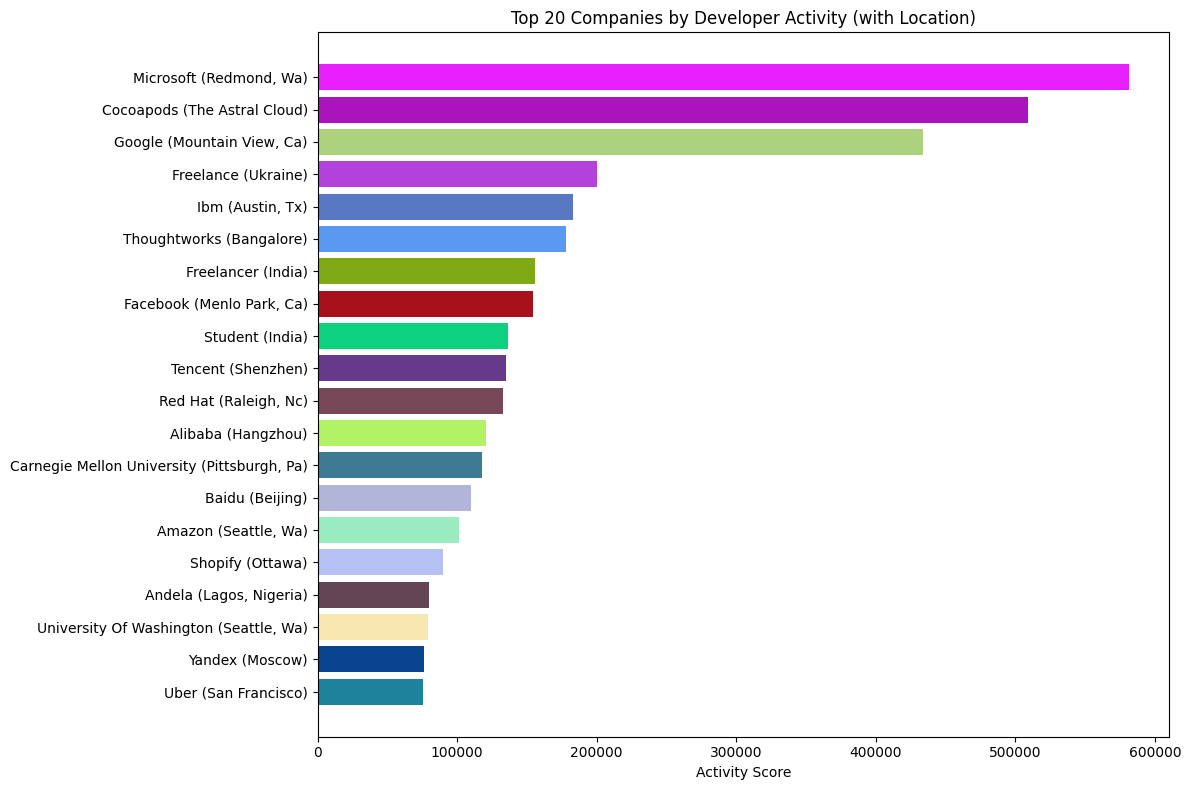

In [ ]:
# Collect top 20 with location
top_20_pd = top_20_final.orderBy("activity_score", ascending=False).limit(20).toPandas()

import matplotlib.pyplot as plt
import numpy as np

# Add a label that combines company and location
top_20_pd["label"] = top_20_pd["company"].str.title() + " (" + top_20_pd["location"].fillna("Unknown").str.title() + ")"

# Generate random colors
colors = np.random.rand(len(top_20_pd), 3)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_20_pd["label"], top_20_pd["activity_score"], color=colors)
plt.xlabel("Activity Score")
plt.title("Top 20 Companies by Developer Activity (with Location)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## SQL query for above steps
-- 1. Count commits per user
WITH commit_counts AS (

  SELECT

    committer_id,

    COUNT(*) AS commit_count

  FROM commits

  WHERE YEAR(generate_at) BETWEEN 2008 AND 2018

  GROUP BY committer_id

)

SELECT * FROM commit_counts;



-- 2. Join with users and compute activity score

users_enriched AS (

  SELECT

    LOWER(TRIM(REPLACE(u.company, '@', ''))) AS company_cleaned,

    LOWER(TRIM(u.location)) AS location,

    COALESCE(c.commit_count, 0) AS commit_count,
    
    u.public_repos,

    u.followers,

    u.public_gists,

    (

      3 * COALESCE(c.commit_count, 0) +

      2 * u.public_repos +

      1 * u.followers +

      0.5 * u.public_gists

    ) AS activity_score

  FROM users_with_score u

  LEFT JOIN commit_counts c ON u.id = c.committer_id

  WHERE u.company IS NOT NULL AND TRIM(LOWER(u.company)) NOT IN ('', 'none')

),


-- 3. Sum activity score per company

company_scores AS (

  SELECT

    company_cleaned,

    SUM(activity_score) AS total_activity_score

  FROM users_enriched

  GROUP BY company_cleaned

),

-- 4. Find most common location per company

location_mode AS (

  SELECT

    company_cleaned,

    location,

    ROW_NUMBER() OVER (PARTITION BY company_cleaned ORDER BY COUNT(*) DESC) AS
    row_num

  FROM users_enriched

  WHERE location IS NOT NULL AND location != ''

  GROUP BY company_cleaned, location

)

-- 5. Final output: top 20 companies with top location

SELECT

  cs.company_cleaned AS company,

  cs.total_activity_score,

  lm.location

FROM

  company_scores cs

LEFT JOIN

  location_mode lm

  ON cs.company_cleaned = lm.company_cleaned AND lm.row_num = 1

ORDER BY

  cs.total_activity_score DESC
  
LIMIT 20;


Download Top 500 companies data in a Excel file

# Load data in Snowflake

In [ ]:
!pip install pyspark
!pip install python-dotenv
!pip install snowflake-connector-python

In [ ]:
import snowflake.connector
from google.colab import userdata

# Replace the placeholders with your actual Snowflake credentials
conn = snowflake.connector.connect(
    user = userdata.get('snowflake_user'),
    password = userdata.get('snowflake_password'),
    account= userdata.get('snowflake_accounr'),
    warehouse='COMPUTE_WH',
    database='BIGDATA_GITHUB',
    schema='RAW',
    role='ACCOUNTADMIN'
)

In [ ]:
cur = conn.cursor()
url = 'azure://matthewleffler1.blob.core.windows.net/kaggle-datasets/analytics/top_20_company_activities'

try:
    cur.execute("BEGIN;")
    cur.execute(f"""
        CREATE OR REPLACE STAGE BIGDATA_GITHUB.ANALYTICS.azure_parquet_stage_top20_companies_activities
          URL = '{url}'
          CREDENTIALS = (
            AZURE_SAS_TOKEN = '{userdata.get('AZURE_SAS_TOKEN')}'
          )
          FILE_FORMAT = (TYPE = PARQUET);
        """)
    cur.execute("COMMIT;")
    print(f"Successfullt created stage.")
except Exception as e:
    cur.execute("ROLLBACK;")
    print(f"Error creating database object: {e}")
finally:
    cur.close()

Successfullt created stage.


In [ ]:
cur = conn.cursor()
table_name = 'BIGDATA_GITHUB.ANALYTICS.TOP_COMPANY_ACTIVITY_SUMMARY'

try:
    cur.execute("BEGIN;")
    cur.execute(f"""
      COPY INTO {table_name}
      FROM @BIGDATA_GITHUB.ANALYTICS.AZURE_PARQUET_STAGE_TOP20_COMPANIES_ACTIVITIES
      FILE_FORMAT = (TYPE = PARQUET)
      MATCH_BY_COLUMN_NAME = CASE_INSENSITIVE
      ON_ERROR = CONTINUE;
          """)
    cur.execute("COMMIT;")
    print(f"Data loaded into {table_name} successfully.")
except Exception as e:
    cur.execute("ROLLBACK;")
    print(f"Error loading data: {e}")
finally:
    cur.close()

Data loaded into BIGDATA_GITHUB.ANALYTICS.TOP_COMPANY_ACTIVITY_SUMMARY successfully.
